In [16]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, "../")

import motiflets.motiflets as ml
from motiflets.competitors import *
from motiflets.plotting import *

import subprocess
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

import warnings
warnings.simplefilter("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#  Load fNIRS Dataset

Dataset Original Length n:  10401
Dataset Sampled Length n:  10401


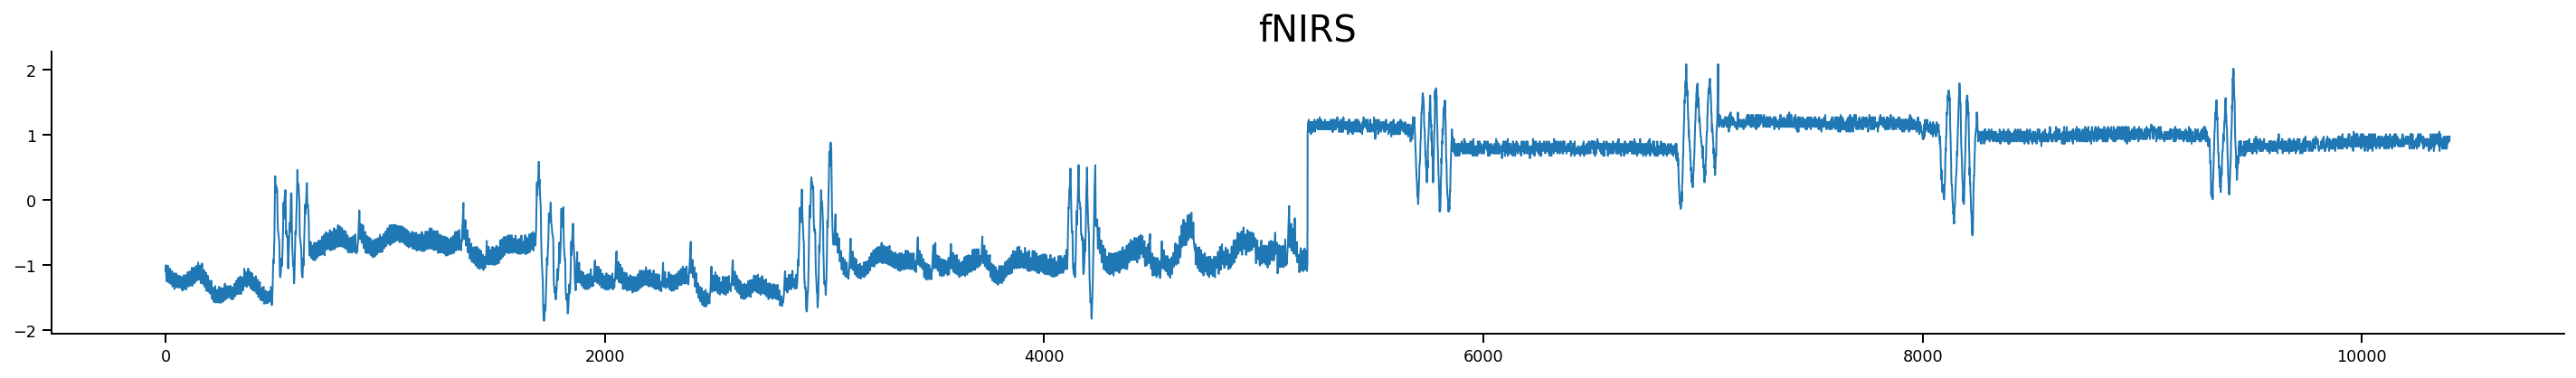

In [17]:
file = "fNIRS_subLen_600.csv" 
ds_name = "fNIRS"
series = ml.read_dataset_with_index(file) 
data = series.values
plot_dataset(file, series, ds_name=ds_name)

# Parameters

In [18]:
df = pd.DataFrame() # TOP-1
df2 = pd.DataFrame() # TOP-2

rerun_all_jars = False
motif_length = 160
ks = 20
dataset = os.getcwd() + '/../datasets/' + file
print(dataset)

/Users/bzcschae/workspace/motiflets_paper/notebooks/../datasets/fNIRS_subLen_600.csv


# k-Motiflets

## First, we learn the size k of the motif set

Compute ks: 100%|██████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.51it/s]


Chosen window-size: 160
Identified Elbow Points [ 4  8 17]
Filtered Elbow Points [4, 17]


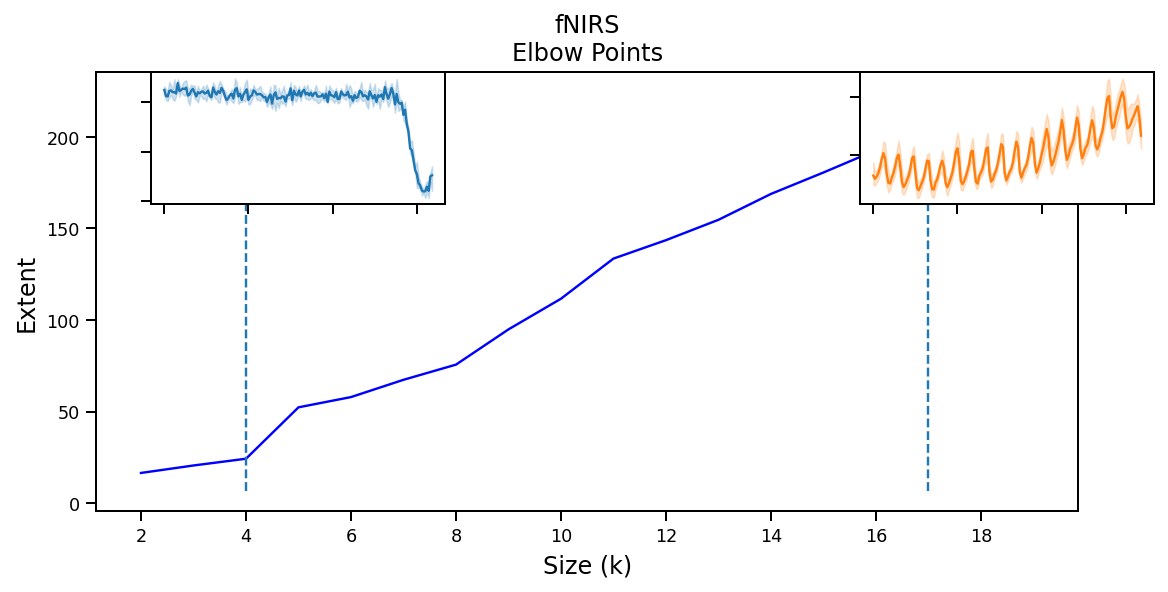

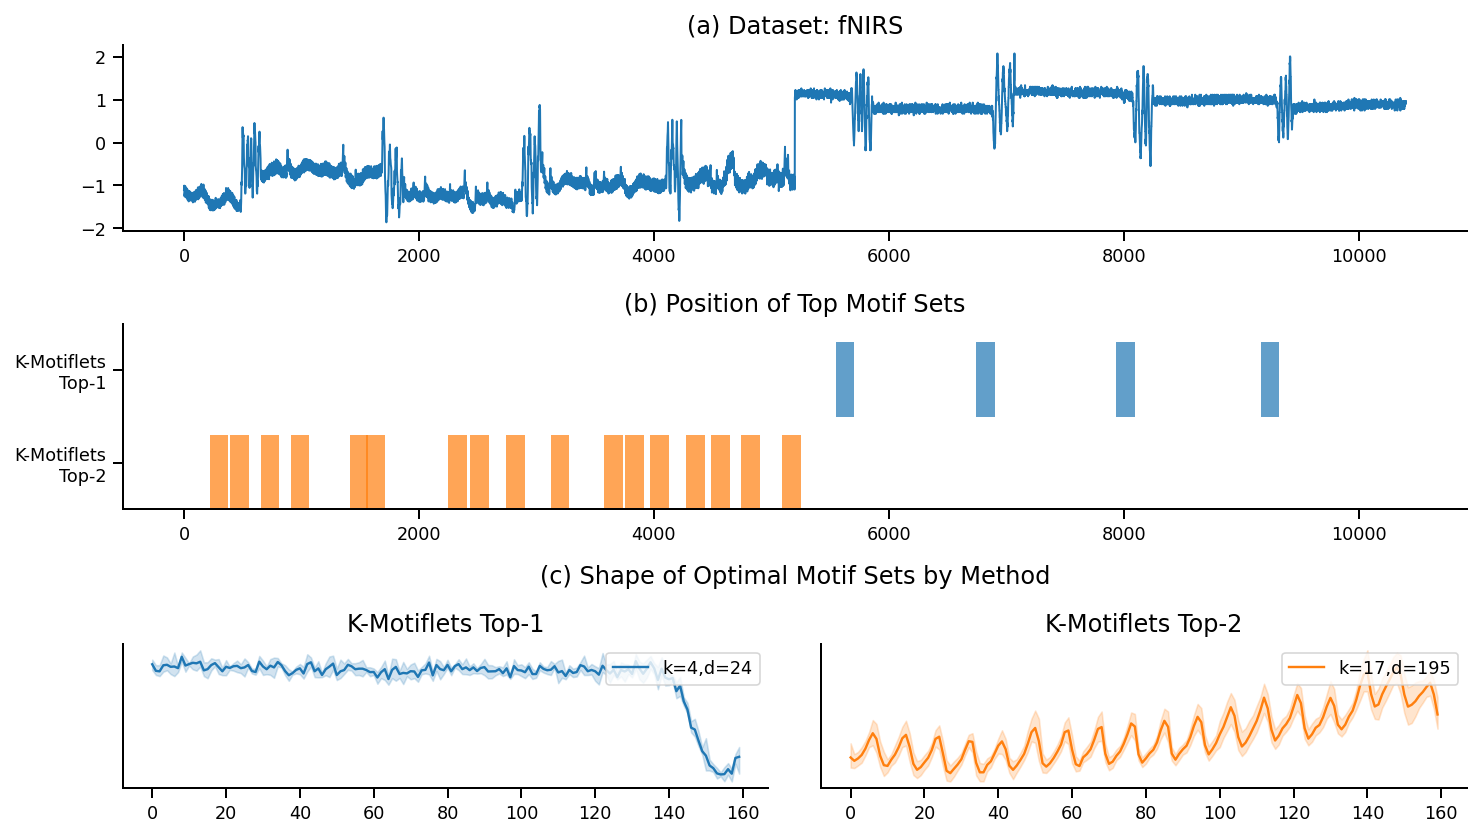

In [19]:
dists, motiflets, elbow_points = plot_elbow(
    ks, series, file, ds_name=ds_name, plot_elbows=True,
    motif_length=motif_length, method_name="K-Motiflets")

In [5]:
D_full = ml.compute_distances_full(data, motif_length)

df["Motiflets Top-1"] = [motiflets[elbow_points[-1]]]
df2["Motiflets Top-2"] = [motiflets[elbow_points[-2]]]
r_top1 = ml.get_radius(D_full, motiflets[elbow_points[-1]])
r_top2 = ml.get_radius(D_full, motiflets[elbow_points[-2]])
print("Radius r of TOP-2 Motifs", r_top1, r_top2)
print("Extent d of TOP-1 Motif", ml.get_pairwise_extent(D_full, motiflets[elbow_points[-1]]))

Radius r of TOP-2 Motifs 120.5687026977539 21.33243751525879
Extent d of TOP-1 Motif 195.35789489746094


# Oracle

The competitor methods have two input parameters: length l and the radius r. These have to be tuned using trial-and-error. We pretend to have an oracle on the length l and the radius r. 

In [6]:
radii = np.array([r_top2, r_top1])
print("Best Radii\t", radii)
print("Best Lengths\t", motif_length)

Best Radii	 [ 21.33243752 120.5687027 ]
Best Lengths	 160


# Set Finder
Runs java code:
- https://sites.google.com/site/timeseriesmotifsets/

In [7]:
rs = np.array([r_top2*1.5, r_top1*0.9])
mls = motif_length

if rerun_all_jars:
    output = subprocess.call(['java', '-jar', 
       '../jars/set_finder.jar',
       dataset,
       'SetFinder',
       str(list(rs+1)),
       str(mls)])

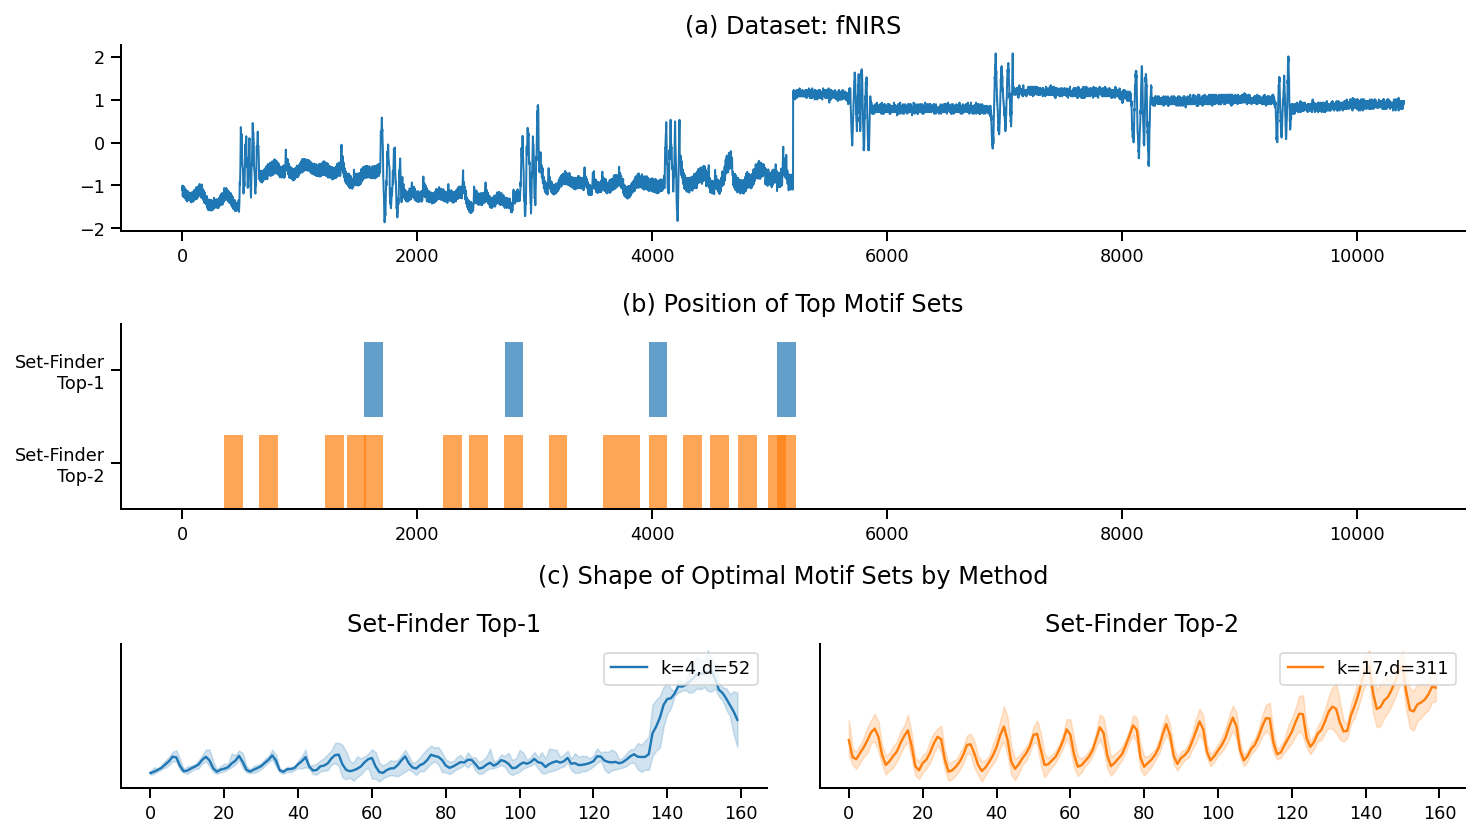

In [8]:
# run jave code first       
ms_set_finder = [
	[1551, 2745, 3969, 5064],
	[4494, 359, 653, 1214, 1402, 1550, 2223, 2442, 2743, 3120, 3578, 3737, 3970, 4262, 4732, 4983, 5064],
]

motifset = plot_competitors(series, ds_name, ms_set_finder, motif_length, 
                            filter=False, prefix="Set-Finder")

df["Set Finder Top-1"] = [motifset[-1]]
df2["Set Finder Top-2"] = [motifset[-2]]


# EMMA

Runs Java Code
- https://github.com/jMotif/SAX

In [9]:
rs = np.array([r_top2*2.5, r_top1*1.39])
mls = motif_length

if rerun_all_jars:
    output = subprocess.call(['java', '-jar', 
       '../jars/emma.jar',
       dataset,
       str(list(rs)),
       str(mls)])

Filtered Elbow Points [0, 1]


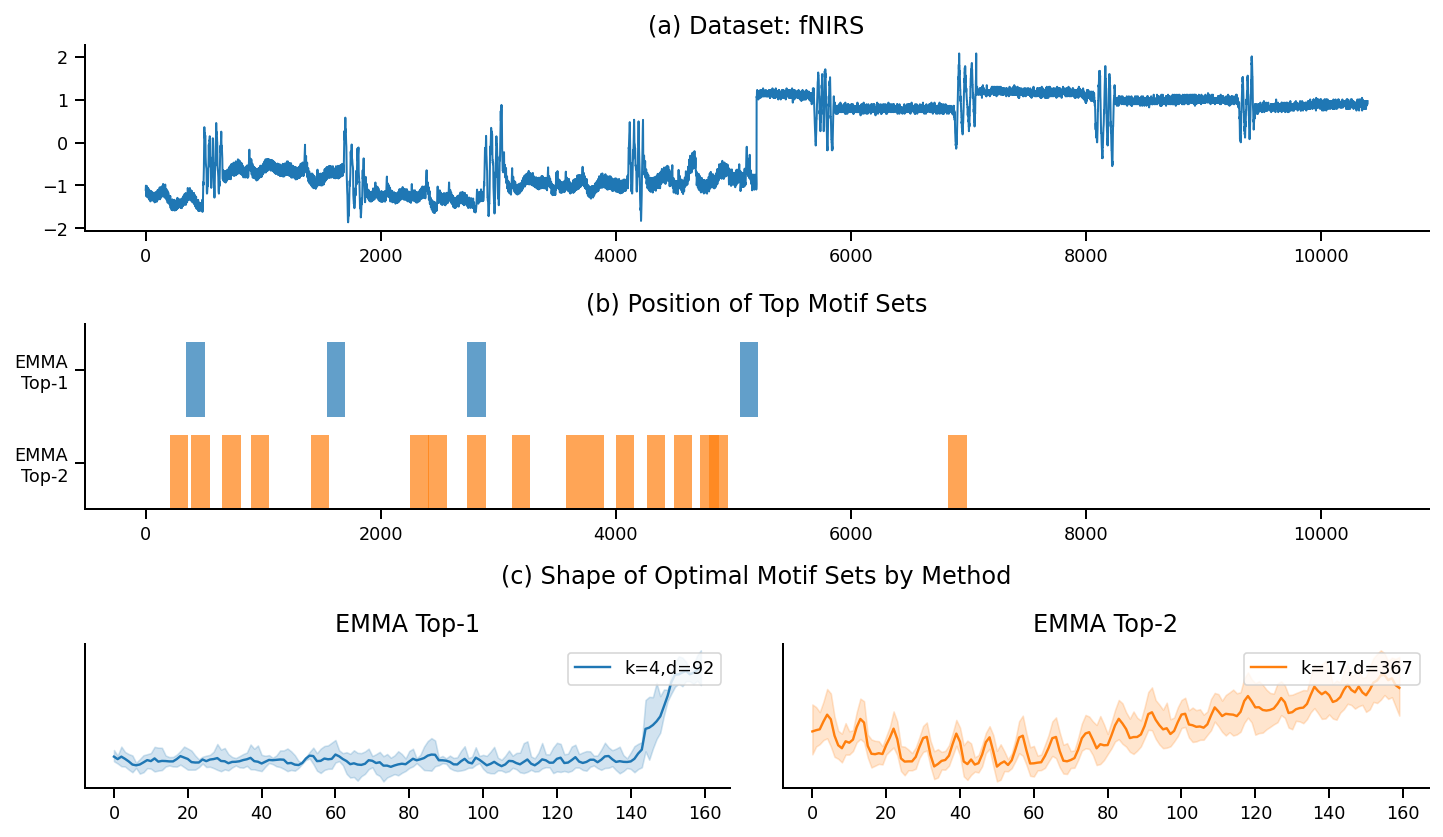

In [10]:
# run jave code first 
ms_emma=[
	[346, 1539, 2734, 5056],
	[204, 385, 652, 894, 1405, 2251, 2407, 2736, 3115, 3580, 3739, 3999, 4265, 4494, 4718, 4798, 6833],
]

motifset = plot_competitors(series, ds_name, ms_emma, motif_length, prefix="EMMA")

df["EMMA Top-1"] = [motifset[-1]]
df2["EMMA Top-2"] = [motifset[-2]]

# Valmod Motif Sets
based on own (fixed-length) implementation

Filtered Elbow Points [1, 2, 3, 4]


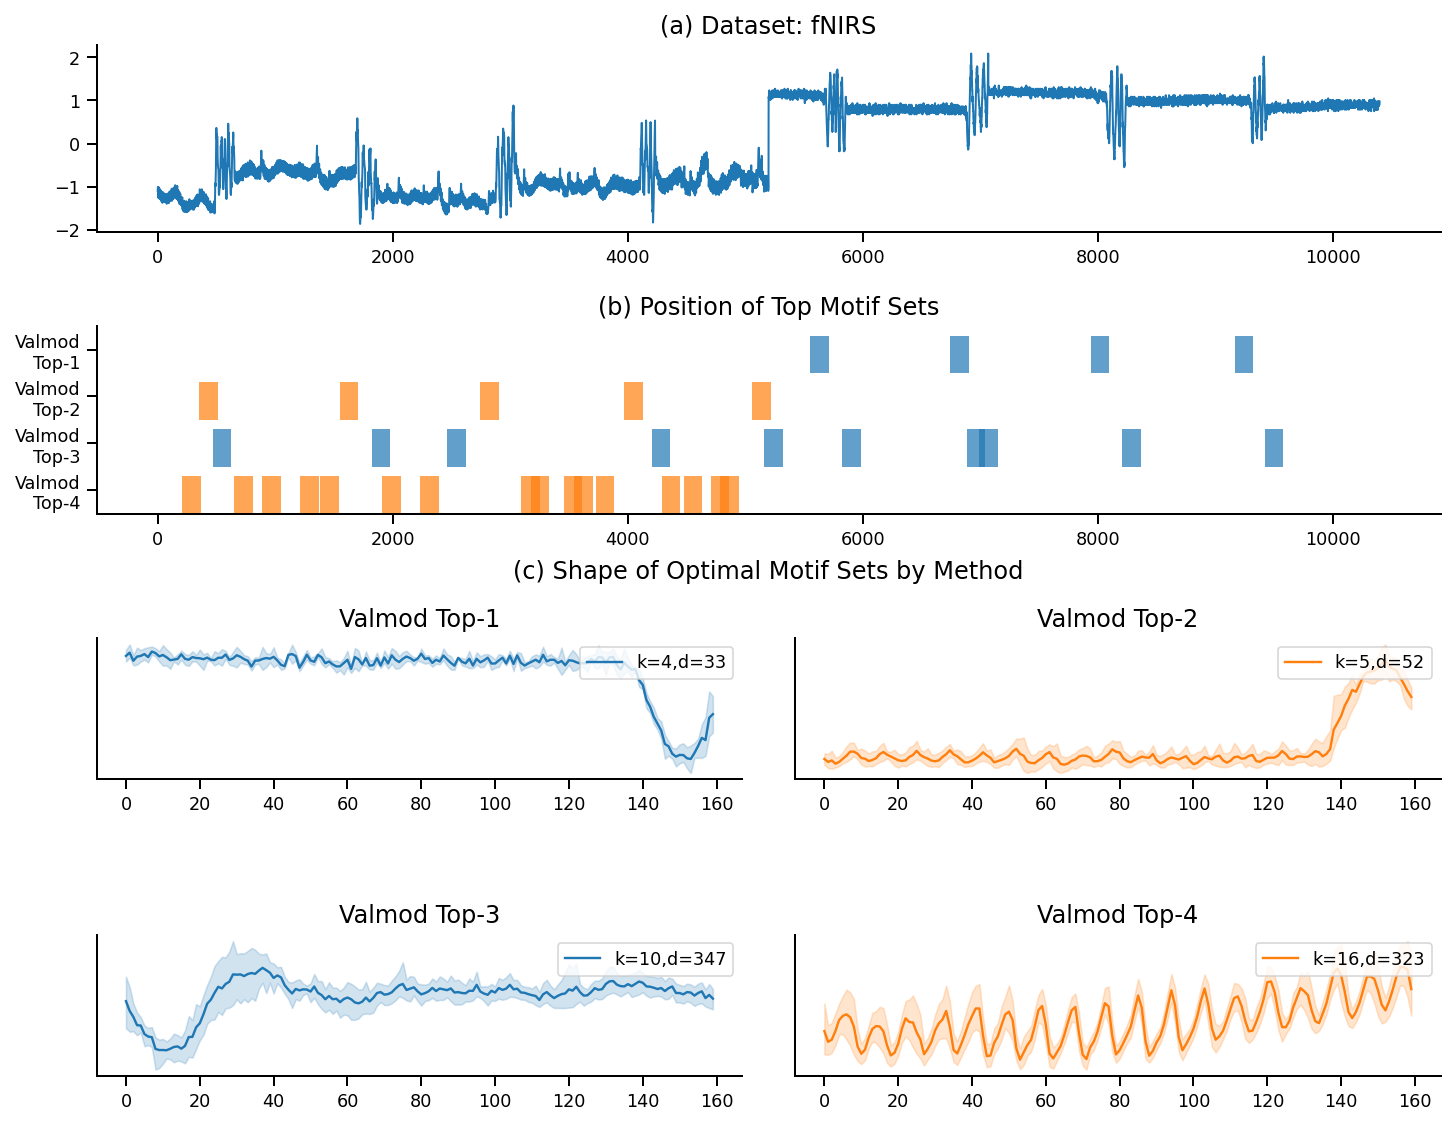

In [11]:
mls = motif_length
ms_valmod = list(get_valmod_motif_set_ranged(data, file, mls, max_r=r_top1*1.9))
motifset = plot_competitors(series, ds_name, ms_valmod, mls, prefix="Valmod")

df["VALMOD Top-1"] = [motifset[-1]]
df2["VALMOD Top-2"] = [motifset[0]]

# Learning Motifs
See Java Code

In [12]:
rs = np.array([r_top2*1.2, r_top1*0.9])
mls = motif_length

if rerun_all_jars:
    output = subprocess.call(['java', '-jar', 
       '../jars/latent_motifs.jar',
       dataset,
       str(list(rs+1)),
       str(mls)])

Filtered Elbow Points [0, 1]


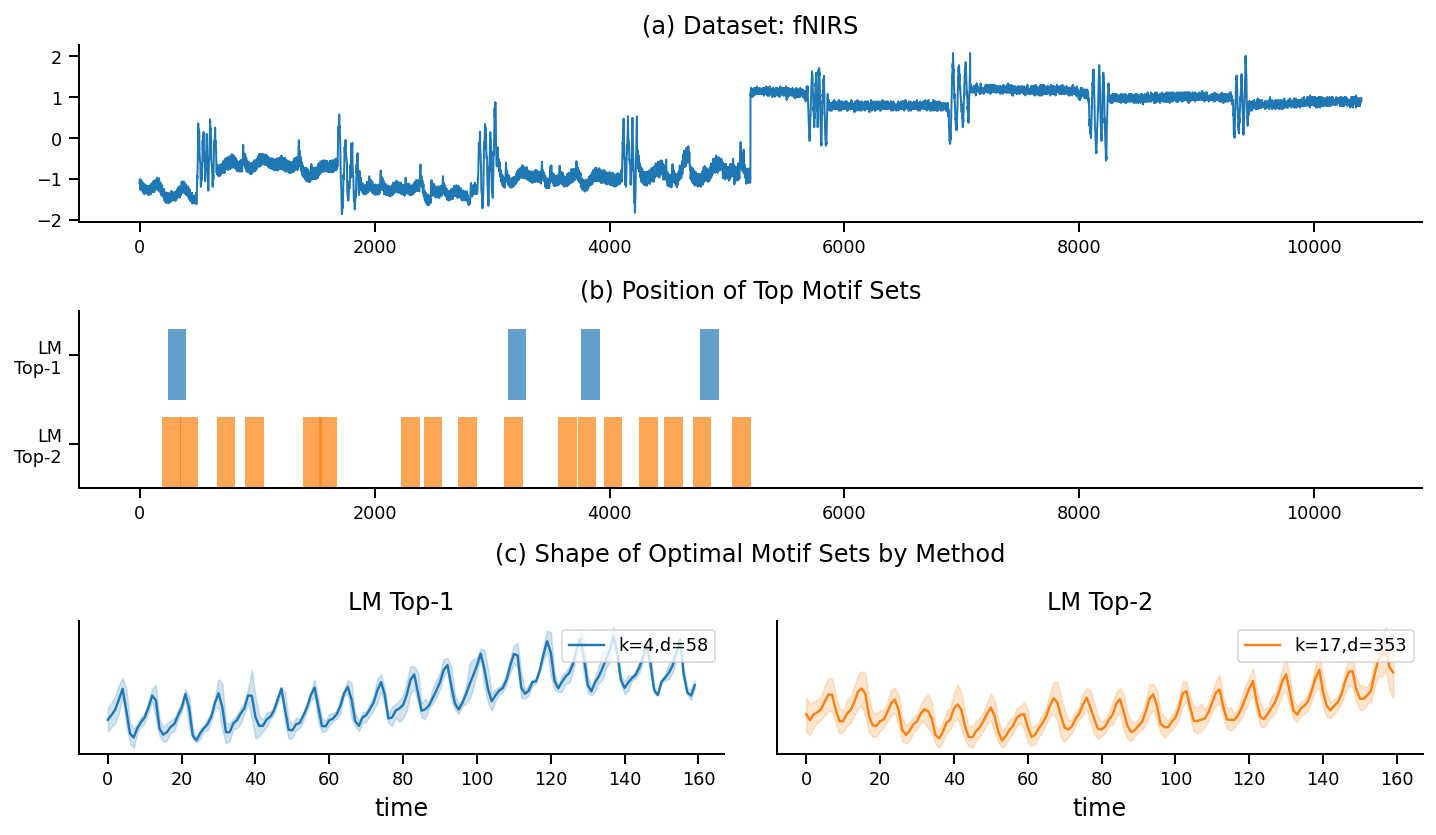

In [13]:
ms_learning_motifs = np.array([
	[239,3132,3758,4771,],
	[193,342,655,899,1393,1525,2224,2417,2714,3103,3562,3730,3951,4255,4467,4708,5046,],
])

    
motifset = plot_competitors(data, ds_name, ms_learning_motifs, motif_length, prefix="LM")

df["LM Top-1"] = [motifset[-1]]
df2["LM Top-2"] = [motifset[-2]]


# Comparison

In [14]:
df_all = (pd.concat([df, df2], axis=1)).T
df_all.rename(columns={0:"offsets"}, inplace=True)
df_all

,offsets
Motiflets Top-1,"[219, 4742, 1411, 4486, 3121, 3579, 4272, 908,..."
Set Finder Top-1,"[4494, 359, 653, 1214, 1402, 1550, 2223, 2442,..."
EMMA Top-1,"[204, 385, 652, 894, 1405, 2251, 2407, 2736, 3..."
VALMOD Top-1,"[209, 653, 891, 1215, 1385, 1913, 2232, 3094, ..."
LM Top-1,"[193, 342, 655, 899, 1393, 1525, 2224, 2417, 2..."
Motiflets Top-2,"[5548, 6744, 7937, 9164]"
Set Finder Top-2,"[1551, 2745, 3969, 5064]"
EMMA Top-2,"[346, 1539, 2734, 5056]"
VALMOD Top-2,"[5551, 6747, 7942, 9168]"
LM Top-2,"[239, 3132, 3758, 4771]"


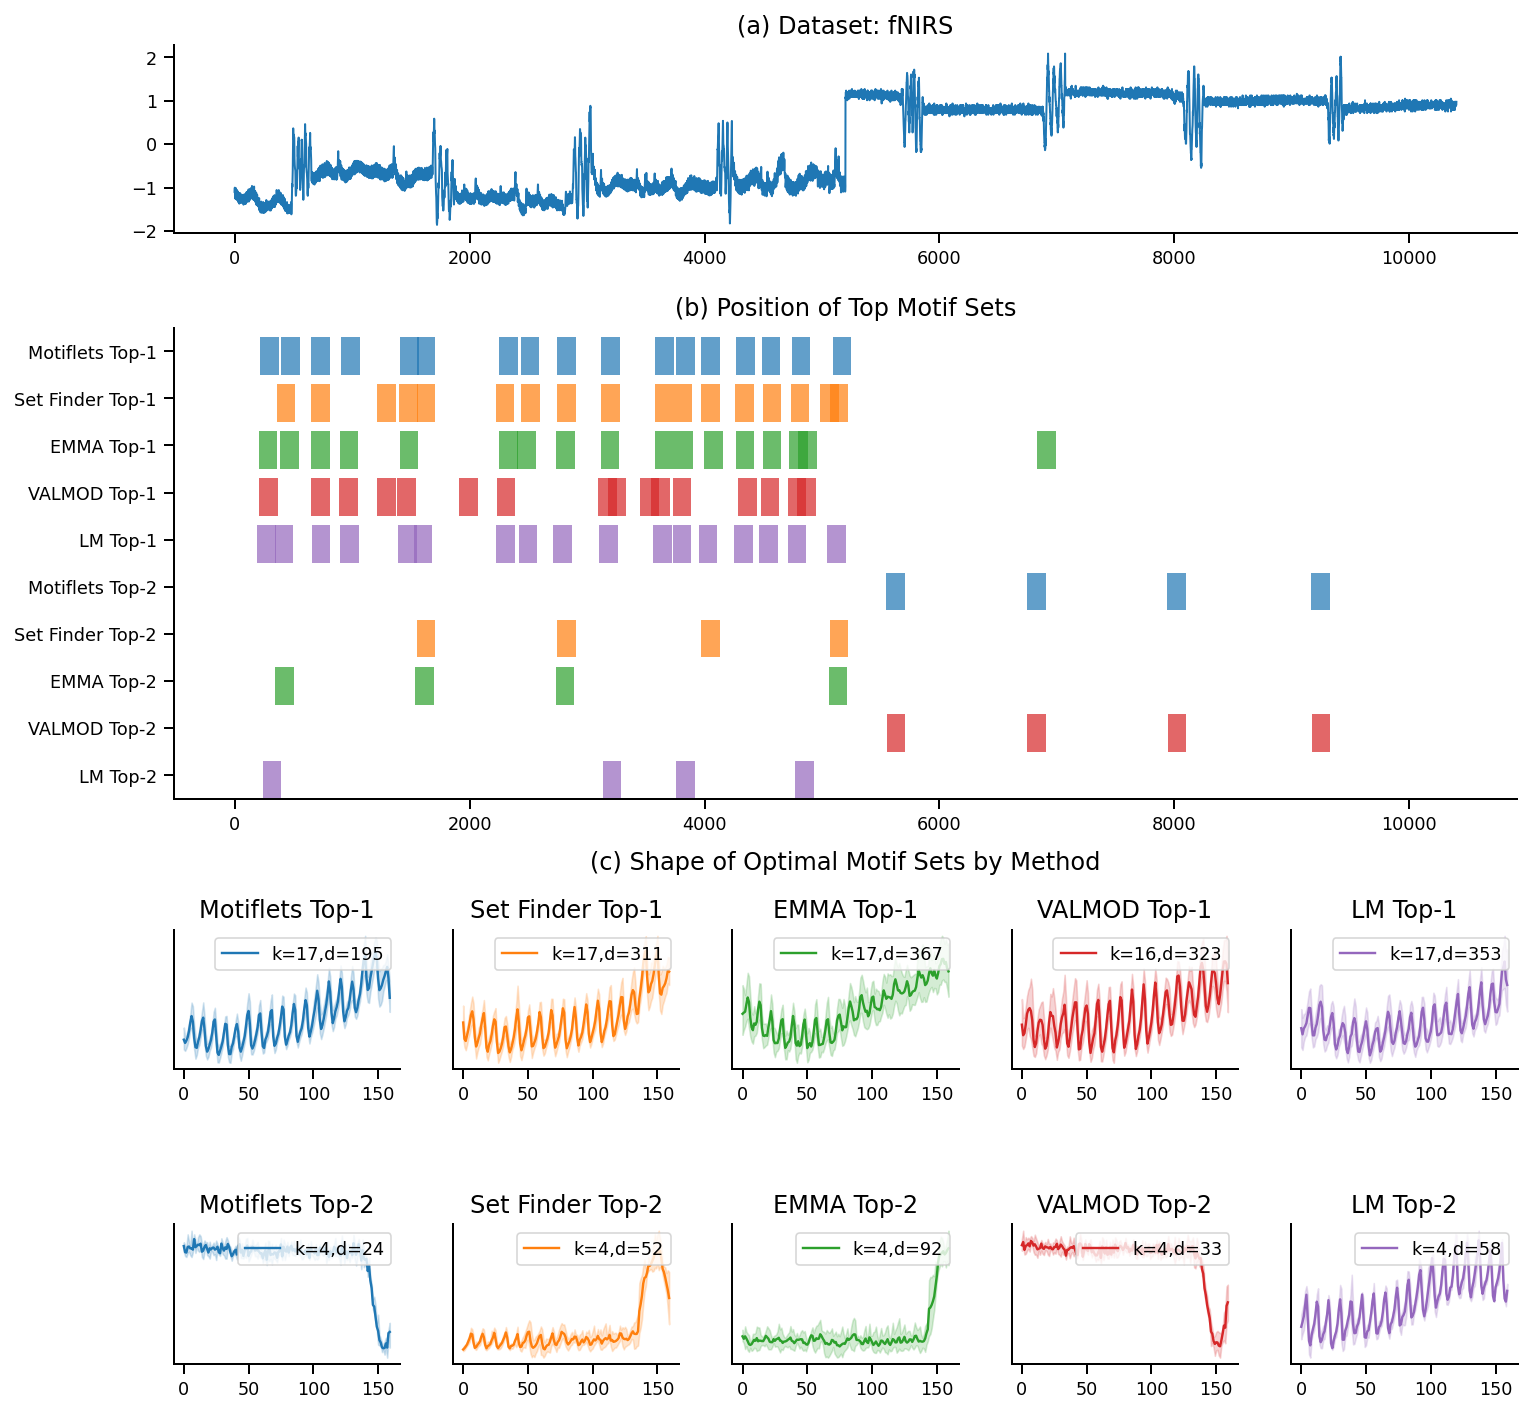

In [15]:
motifsets = np.array(df_all["offsets"].values)
plot_all_competitors(series, ds_name, motifsets, motif_length, 
                     method_names=df_all.index.values)